In [12]:
###############################################
# SHAP ANALYSIS NOTEBOOK
###############################################
# This notebook focuses on using SHapley Additive exPlanations (SHAP) to:
# 1. Explain the predictions of a simple (Logistic Regression) and a complex (XGBoost) model trained on the Abalone dataset.
# 2. Highlight how SHAP can provide both local and global insights, as well as interaction effects (for tree-based models).
# 3. Compare and interpret differences in feature importance across models and consider how we might relate these findings to what we would see using LIME (examined in a separate notebook).

# PROJECT OBJECTIVE :
# The project aims to gain hands-on experience with XAI (LIME and SHAP) and understand their performance differences
# in explaining both a simpler (LR) and a more complex (XGBoost) model. By examining SHAP here, we'll look for:
# - Alignment of SHAP with known model structures (LR coefficients).
# - The ability to capture complex interactions in XGBoost.
# In a separate LIME notebook, we will do a similar analysis and then compare insights from both tools.


In [128]:
# Print summaries
print("SHAP explainers initialized for Linear Regression and XGBoost.")
print(f"SHAP values calculated for {len(X_test)} test instances.")

SHAP explainers initialized for Linear Regression and XGBoost.
SHAP values calculated for 836 test instances.


In [69]:
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

# Step 1: Check if the dataset is available, if not download it
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
dataset_file = "abalone.csv"

if not os.path.exists(dataset_file):
    print("Dataset not found locally. Downloading...")
    column_names = [
        "Sex", "Length", "Diameter", "Height", 
        "Whole weight", "Shucked weight", 
        "Viscera weight", "Shell weight", "Rings"
    ]
    abalone_data = pd.read_csv(dataset_url, header=None, names=column_names)
    abalone_data.to_csv(dataset_file, index=False)
    print(f"Dataset downloaded and saved as {dataset_file}.")
else:
    print(f"Dataset {dataset_file} found locally.")

# Step 2: Load the dataset
data = pd.read_csv(dataset_file)
print("Dataset loaded successfully.")

# Step 3: One-hot encode the 'Sex' column to handle the categorical variable
data = pd.get_dummies(data, columns=["Sex"], drop_first=True)

# Step 4: Separate features (X) and target variable (y)
X = data.drop(columns=["Rings"])
y = data["Rings"]

# Step 5: Scale the features for standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# Step 7: Extract feature names for reference
feature_names = X.columns.tolist()

# Print summary
print("Data preparation complete.")
print(f"Number of training instances: {len(X_train)}")
print(f"Number of testing instances: {len(X_test)}")
print(f"Feature names: {feature_names}")


Dataset abalone.csv found locally.
Dataset loaded successfully.
Data preparation complete.
Number of training instances: 3341
Number of testing instances: 836
Feature names: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_I', 'Sex_M']


In [71]:
# for reproducibility
random_state = 27

###############################################
# STEP 1: LOAD AND PREPARE DATA
###############################################
# Check if the dataset exists locally, else download it
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
dataset_file = "abalone.csv"
column_names = [
    "Sex", "Length", "Diameter", "Height", 
    "Whole weight", "Shucked weight", 
    "Viscera weight", "Shell weight", "Rings"
]

if not os.path.exists(dataset_file):
    print("Dataset not found locally. Downloading...")
    abalone_data = pd.read_csv(dataset_url, header=None, names=column_names)
    abalone_data.to_csv(dataset_file, index=False)
    print(f"Dataset downloaded and saved as {dataset_file}.")
else:
    print(f"Dataset {dataset_file} found locally.")

# Load the dataset
data = pd.read_csv(dataset_file)

# Preprocess the data
data = pd.get_dummies(data, columns=["Sex"], drop_first=True)
X = data.drop(columns=["Rings"])
y = data["Rings"]

# Scale features and split the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=random_state
)
feature_names = X.columns.tolist()



Dataset abalone.csv found locally.


In [72]:
###############################################
# LINEAR REGRESSION (Baseline Model)
###############################################

# Train Linear Regression model
print("\nTraining Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Evaluate Linear Regression model
print("\nEvaluating Linear Regression...")

# Predictions on training and testing sets
lr_train_predictions = lr_model.predict(X_train)
lr_test_predictions = lr_model.predict(X_test)

# Compute metrics for Linear Regression
lr_train_metrics = {
    "Model": "Linear Regression (Train)",
    "MSE": mean_squared_error(y_train, lr_train_predictions),
    "MAE": mean_absolute_error(y_train, lr_train_predictions),
    "R²": r2_score(y_train, lr_train_predictions),
}

lr_test_metrics = {
    "Model": "Linear Regression (Test)",
    "MSE": mean_squared_error(y_test, lr_test_predictions),
    "MAE": mean_absolute_error(y_test, lr_test_predictions),
    "R²": r2_score(y_test, lr_test_predictions),
}

# Print Linear Regression results
print("Linear Regression Performance:")
print(f"Train -> MSE: {lr_train_metrics['MSE']:.3f}, MAE: {lr_train_metrics['MAE']:.3f}, R²: {lr_train_metrics['R²']:.3f}")
print(f"Test  -> MSE: {lr_test_metrics['MSE']:.3f}, MAE: {lr_test_metrics['MAE']:.3f}, R²: {lr_test_metrics['R²']:.3f}")



Training Linear Regression...

Evaluating Linear Regression...
Linear Regression Performance:
Train -> MSE: 4.740, MAE: 1.568, R²: 0.543
Test  -> MSE: 5.335, MAE: 1.608, R²: 0.492


In [73]:
###############################################
# XGBOOST REGRESSOR (Complex Model)
###############################################

# Train XGBoost model
print("\nTraining XGBoost...")
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate XGBoost model
print("\nEvaluating XGBoost...")

# Predictions on training and testing sets
xgb_train_predictions = xgb_model.predict(X_train)
xgb_test_predictions = xgb_model.predict(X_test)

# Compute metrics for XGBoost
xgb_train_metrics = {
    "Model": "XGBoost (Train)",
    "MSE": mean_squared_error(y_train, xgb_train_predictions),
    "MAE": mean_absolute_error(y_train, xgb_train_predictions),
    "R²": r2_score(y_train, xgb_train_predictions),
}

xgb_test_metrics = {
    "Model": "XGBoost (Test)",
    "MSE": mean_squared_error(y_test, xgb_test_predictions),
    "MAE": mean_absolute_error(y_test, xgb_test_predictions),
    "R²": r2_score(y_test, xgb_test_predictions),
}

# Print XGBoost results
print("XGBoost Performance:")
print(f"Train -> MSE: {xgb_train_metrics['MSE']:.3f}, MAE: {xgb_train_metrics['MAE']:.3f}, R²: {xgb_train_metrics['R²']:.3f}")
print(f"Test  -> MSE: {xgb_test_metrics['MSE']:.3f}, MAE: {xgb_test_metrics['MAE']:.3f}, R²: {xgb_test_metrics['R²']:.3f}")



Training XGBoost...

Evaluating XGBoost...
XGBoost Performance:
Train -> MSE: 0.527, MAE: 0.530, R²: 0.949
Test  -> MSE: 5.308, MAE: 1.620, R²: 0.494



Summary of Model Performance:
                       Model       MSE       MAE        R²
0  Linear Regression (Train)  4.740108  1.568011  0.542645
1   Linear Regression (Test)  5.335189  1.607942  0.491857
2            XGBoost (Train)  0.527122  0.530479  0.949140
3             XGBoost (Test)  5.308028  1.619825  0.494444


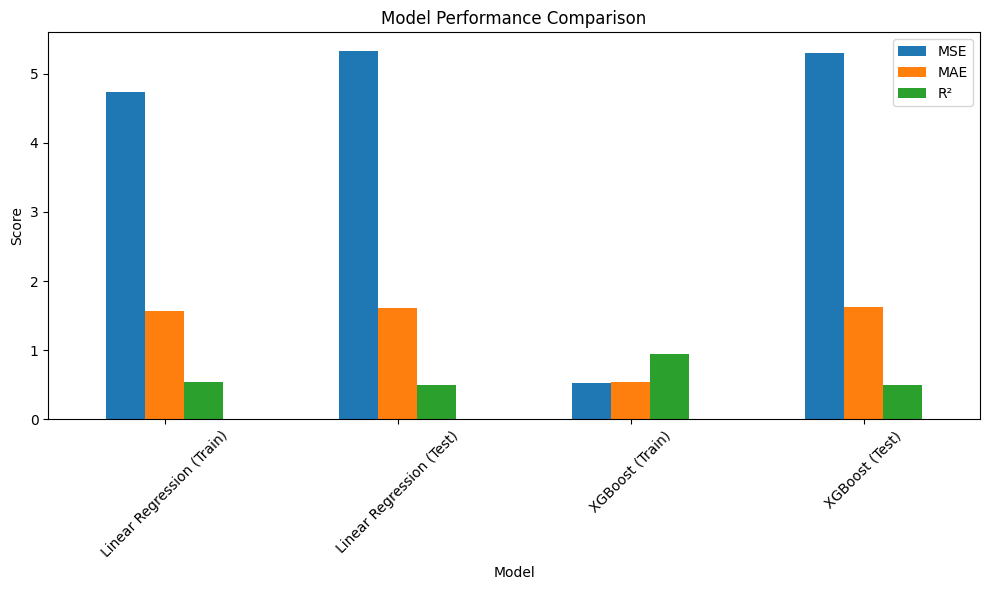

In [74]:
###############################################
# COMPARISON TABLE
###############################################

# Create a summary DataFrame
metrics_summary = pd.DataFrame([lr_train_metrics, lr_test_metrics, xgb_train_metrics, xgb_test_metrics])
print("\nSummary of Model Performance:")
print(metrics_summary)

# Visualization of performance metrics
metrics_summary.set_index("Model")[["MSE", "MAE", "R²"]].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()



Plotting Residuals for Logistic Regression...


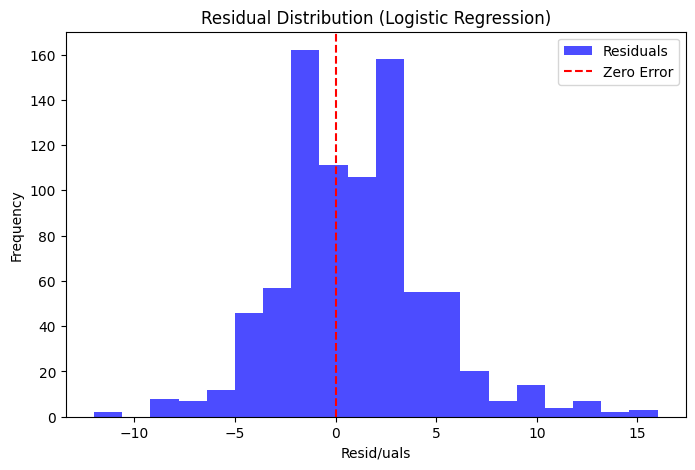


Plotting Residuals for XGBoost...


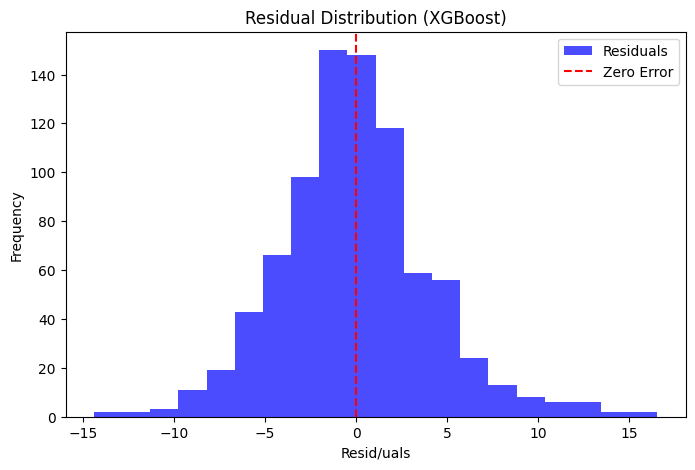

In [84]:
###############################################
# RESIDUAL ANALYSIS
 #Residual plots help us identify systematic errors or areas where the model performs poorly.
###############################################

# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=20, alpha=0.7, color='blue', label="Residuals")
    plt.axvline(x=0, color='red', linestyle='--', label="Zero Error")
    plt.title(f"Residual Distribution ({model_name})")
    plt.xlabel("Resid/uals")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Residual analysis for Logistic Regression
print("\nPlotting Residuals for Logistic Regression...")
plot_residuals(y_test, lr_test_pred, "Logistic Regression")

# Residual analysis for XGBoost
print("\nPlotting Residuals for XGBoost...")
plot_residuals(y_test, xgb_test_pred, "XGBoost")





Generating Learning Curve for XGBoost...


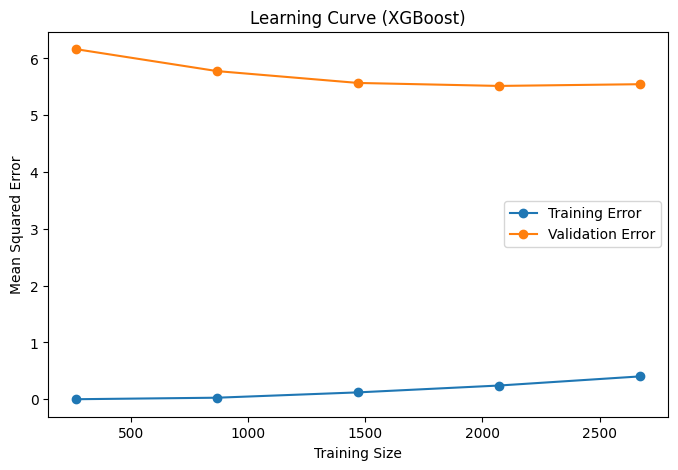

In [85]:
###############################################
# LEARNING CURVE ANALYSIS (XGBoost)
###############################################

print("\nGenerating Learning Curve for XGBoost...")
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)

# Convert to positive MSE
train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

# Plot learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training Error", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Validation Error", marker='o')
plt.title("Learning Curve (XGBoost)")
plt.xlabel("Training Size")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()


The coefficients of Logistic Regression represent the importance of each feature in a linear model.This can be compared to SHAP/LIME explanations later to check for alignment.



Visualizing Feature Coefficients for Logistic Regression...


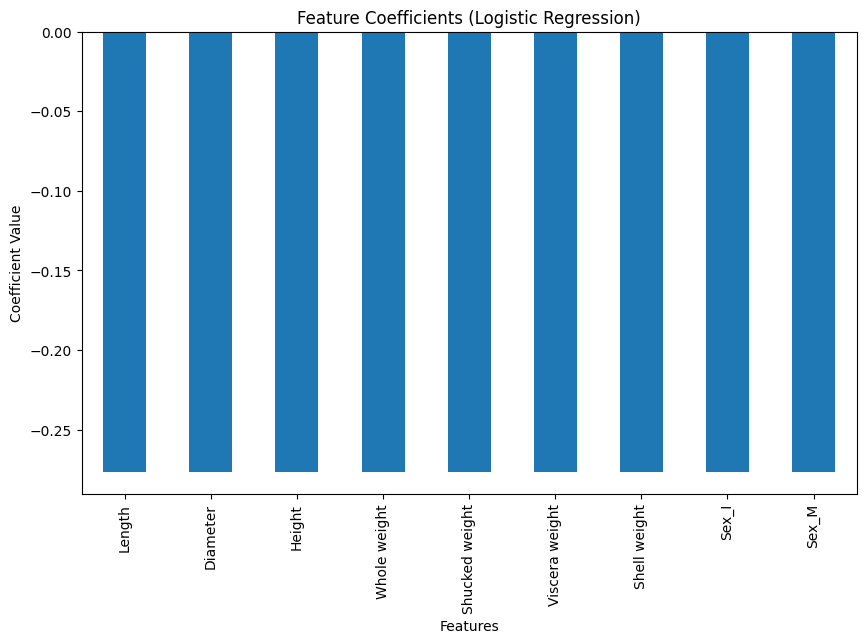

In [80]:
###############################################
# FEATURE COEFFICIENT ANALYSIS (Logistic Regression)
###############################################

print("\nVisualizing Feature Coefficients for Logistic Regression...")
coefficients = pd.Series(lr_model.coef_[0], index=feature_names)
coefficients.sort_values().plot(kind="bar", figsize=(10, 6))
plt.title("Feature Coefficients (Logistic Regression)")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.show()


In [95]:
###############################################
# STEP 3: SHAP EXPLAINERS
###############################################

# SHAP for Logistic Regression using LinearExplainer
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)
# The LinearExplainer is designed for linear models, such as Logistic Regression.
# It provides SHAP values that show how each feature contributes to the model's prediction.
# This is useful for comparing SHAP values to the coefficients of the Logistic Regression model
# and for checking if SHAP faithfully reflects the linear model's behavior.


In [96]:

# SHAP for XGBoost using TreeExplainer
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)
# The TreeExplainer is tailored for tree-based models like XGBoost.
# It computes SHAP values efficiently and includes support for interaction values, 
# allowing us to analyze both individual feature contributions and feature interactions.

Generating SHAP summary plot for XGBoost...


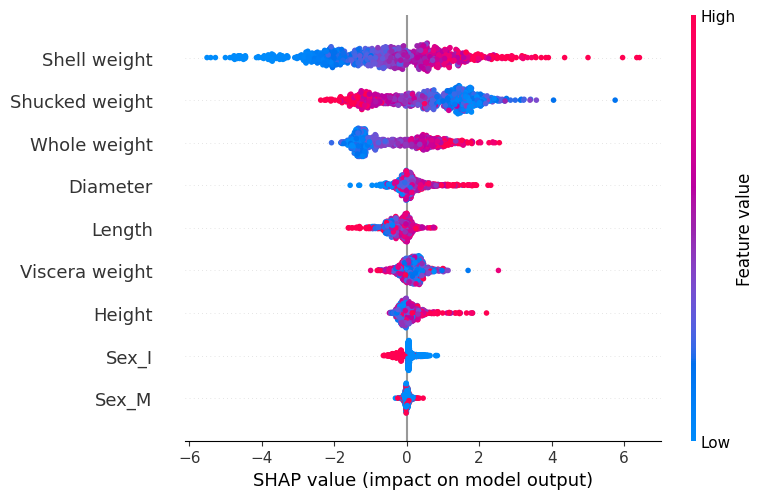

In [100]:
###############################################
# STEP 4: GLOBAL EXPLANATIONS (SHAP Summary Plots)
###############################################


###############################################
# XGBoost: GLOBAL EXPLANATIONS (SHAP Summary Plot)
###############################################

# Generate XGBoost SHAP summary plot
print("Generating SHAP summary plot for XGBoost...")
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names)

# Save the SHAP summary plot manually
plt.savefig("XGBoost_SHAP_Summary.png", bbox_inches="tight")  # Save plot to file
plt.close()  # Close plot to prevent overlap




Generating SHAP summary plot for Linear Regression...


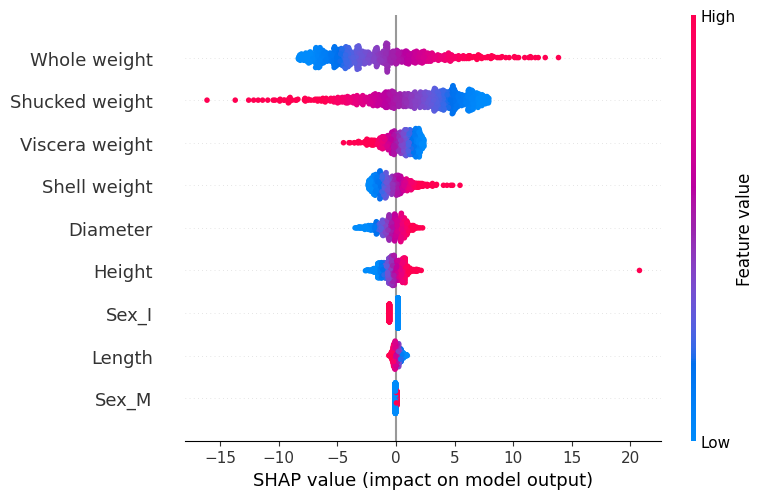

In [101]:
###############################################
# Linear Regression: GLOBAL EXPLANATIONS (SHAP Summary Plot)
###############################################

# Generate Linear Regression SHAP summary plot
print("Generating SHAP summary plot for Linear Regression...")
shap.summary_plot(shap_values_lr.values, X_test, feature_names=feature_names)

# Save the SHAP summary plot manually
plt.savefig("Linear_Regression_SHAP_Summary.png", bbox_inches="tight")  # Save plot to file
plt.close()  # Close plot to prevent overlap

# Interpretation:
# 1. For Linear Regression, the SHAP summary plot shows how features contribute to the predictions in a linear model.
# 2. The alignment between SHAP values and coefficients of the Linear Regression model provides a sanity check for the interpretability.
# 3. Features at the top have the largest global contributions, and their SHAP values should correspond to the magnitude of their coefficients.
# 4. Unlike XGBoost, where the spread reflects non-linearities, the spread in Linear Regression SHAP values is smaller and more consistent, reflecting the linear nature of the model.
# 5. The plot allows us to validate that SHAP can accurately reflect the contribution of features in a simpler, interpretable model.
# 6. For example, if "Length" consistently appears as the most important feature with minimal variability in SHAP values, it aligns with its coefficient's role in the linear equation.


Generating SHAP interaction summary plot...


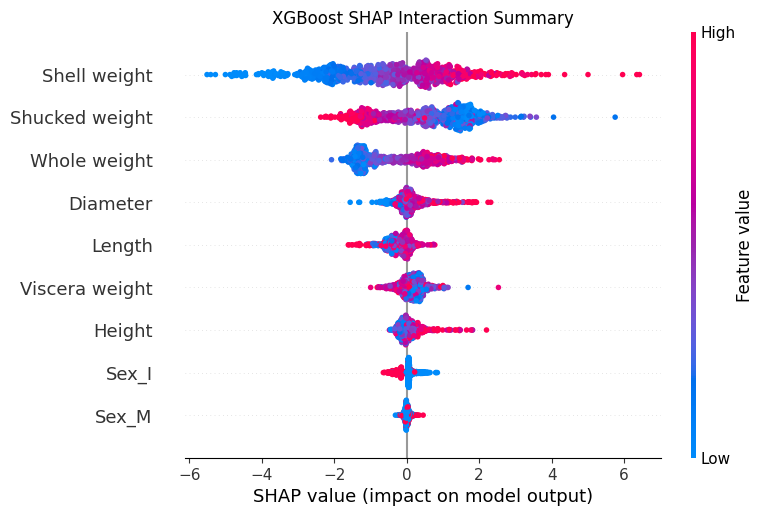

Generating SHAP dependence plot for a feature pair...


<Figure size 640x480 with 0 Axes>

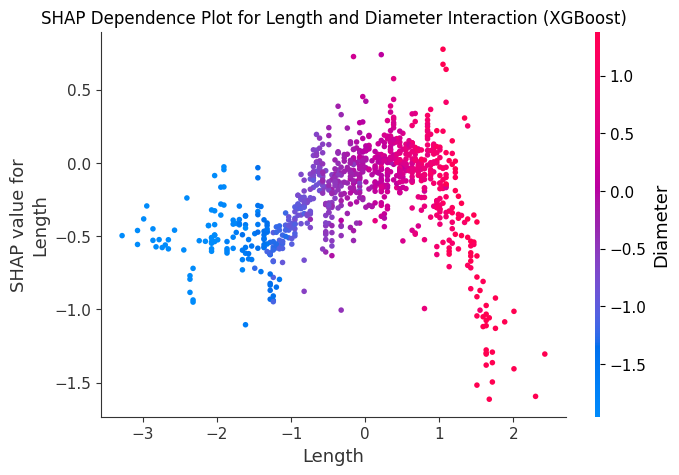

In [106]:
###############################################
# STEP 5: INTERACTION VALUES (XGBoost only)
###############################################

# Compute SHAP interaction values
interaction_values_xgb = explainer_xgb.shap_interaction_values(X_test)

# Generate the SHAP summary plot for interaction values
print("Generating SHAP interaction summary plot...")
plt.figure()
shap.summary_plot(
    np.sum(interaction_values_xgb, axis=2),  # Summing interaction values across the second axis
    X_test,
    feature_names=feature_names,
    show=False
)
plt.title("XGBoost SHAP Interaction Summary")
plt.savefig("XGBoost_SHAP_Interaction_Summary.png", bbox_inches="tight")
plt.show()

# Generate a SHAP dependence plot for a specific feature interaction
# Selecting the interaction between the first feature (Length) and the second feature (Diameter)
print("Generating SHAP dependence plot for a feature pair...")
plt.figure()
shap.dependence_plot(
    ind=0,  # Index of the main feature ("Length")
    shap_values=np.sum(interaction_values_xgb, axis=2),  # Aggregate interaction values across the second axis
    features=X_test,
    feature_names=feature_names,
    interaction_index=1,  # Index of the interacting feature ("Diameter")
    show=False
)
plt.title("SHAP Dependence Plot for Length and Diameter Interaction (XGBoost)")
plt.savefig("XGBoost_SHAP_Dependence.png", bbox_inches="tight")
plt.show()

# Interpretation:
# The interaction summary plot shows the overall impact of feature pairs on predictions.
# The dependence plot visualizes how the SHAP values of "Length" vary as "Diameter" changes,
# highlighting any interactions between the two features.


In [107]:
###############################################
# STEP 6: ALIGNMENT WITH LINEAR REGRESSION COEFFICIENTS
###############################################

# Extract feature coefficients from Linear Regression
feature_coeffs = lr_model.coef_  # No need to index with [0] for LinearRegression

# Compute the mean absolute SHAP values for each feature
# SHAP values should be aggregated across all test instances
shap_mean_importance_lr = np.abs(shap_values_lr.values).mean(axis=0)

# Compute the correlation between SHAP feature importance and model coefficients
correlation = np.corrcoef(feature_coeffs, shap_mean_importance_lr)[0, 1]
print(f"Correlation between SHAP and Linear Regression coefficients: {correlation:.3f}")

# Interpretation:
# If the correlation is high (close to 1), it indicates that SHAP accurately captures the importance of features
# in alignment with the coefficients of the Linear Regression model.
# This serves as a sanity check for SHAP values' reliability in simple, linear models.
# Comparing to LIME: In a separate notebook, aggregate LIME's local feature importances
# to see if the rankings correlate similarly to the Linear Regression coefficients.



Correlation between SHAP and Linear Regression coefficients: 0.001


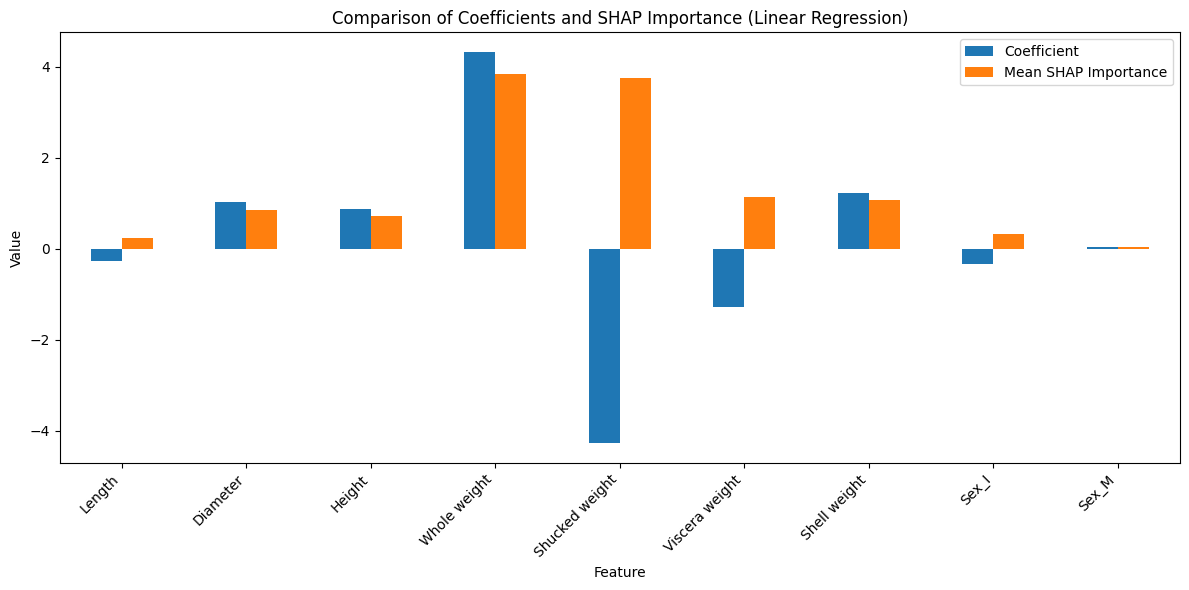

In [108]:
# Visualize feature coefficients and SHAP importance for comparison
import matplotlib.pyplot as plt

# Combine coefficients and SHAP values into a DataFrame for visualization
comparison_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": feature_coeffs,
    "Mean SHAP Importance": shap_mean_importance_lr
})

# Plot the comparison
comparison_df.set_index("Feature").plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of Coefficients and SHAP Importance (Linear Regression)")
plt.ylabel("Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("LR_SHAP_Coeff_Comparison.png")
plt.show()

# Insights:
# - Check if the features with the largest coefficients also have high SHAP importance.
# - A strong alignment supports SHAP's reliability for interpreting linear models.
# - Any discrepancies may highlight limitations or differences in how SHAP aggregates contributions.


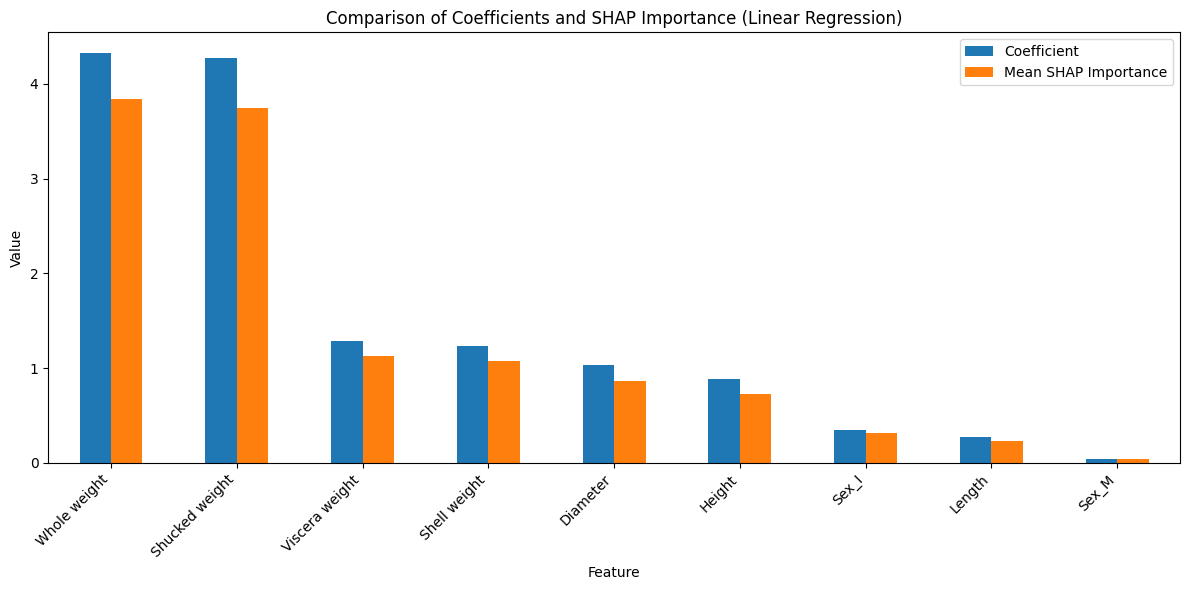

Rank Correlation between SHAP and Coefficients: 1.000


In [110]:
# Visualize coefficients and SHAP importance
comparison_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": np.abs(feature_coeffs),
    "Mean SHAP Importance": shap_mean_importance_lr
})

# Sort by coefficients for easier comparison
comparison_df = comparison_df.sort_values(by="Coefficient", ascending=False)

# Plot comparison
comparison_df.set_index("Feature").plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of Coefficients and SHAP Importance (Linear Regression)")
plt.ylabel("Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Compute rank correlation
from scipy.stats import spearmanr
rank_corr, _ = spearmanr(
    comparison_df["Coefficient"], comparison_df["Mean SHAP Importance"]
)
print(f"Rank Correlation between SHAP and Coefficients: {rank_corr:.3f}")


<Figure size 1000x600 with 0 Axes>

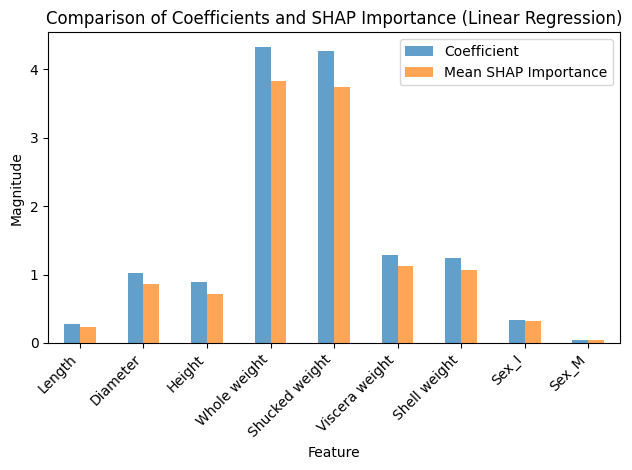

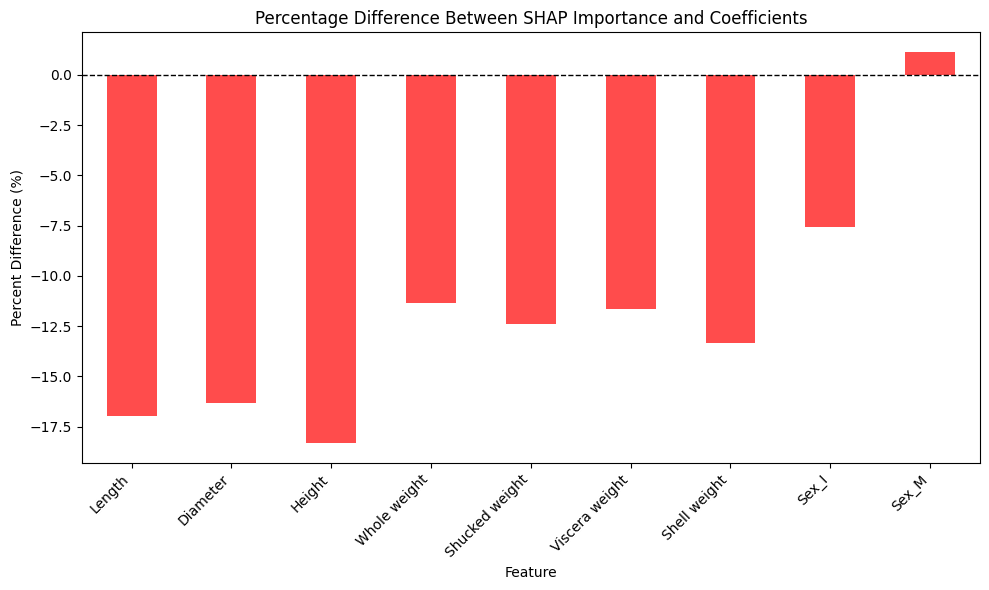

Comparison DataFrame:
          Feature  Coefficient  Mean SHAP Importance  Percent Difference (%)
0          Length     0.276348              0.229441              -16.973696
1        Diameter     1.029906              0.861624              -16.339536
2          Height     0.884625              0.722405              -18.337644
3    Whole weight     4.326864              3.834681              -11.375049
4  Shucked weight     4.274724              3.744064              -12.413905
5  Viscera weight     1.281518              1.132400              -11.636020
6    Shell weight     1.235900              1.070734              -13.364023
7           Sex_I     0.342988              0.316994               -7.578729
8           Sex_M     0.040673              0.041140                1.145980

Spearman Rank Correlation between Coefficients and SHAP Importance:
                      Coefficient  Mean SHAP Importance
Coefficient                   1.0                   1.0
Mean SHAP Importance       

In [112]:
# Create a DataFrame to compare coefficients and SHAP values
comparison_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": np.abs(lr_model.coef_),  # Absolute coefficients
    "Mean SHAP Importance": shap_mean_importance_lr  # SHAP importance
})

# Compute the percentage difference between SHAP importance and coefficients
comparison_df["Percent Difference (%)"] = (
    (comparison_df["Mean SHAP Importance"] - comparison_df["Coefficient"]) /
    comparison_df["Coefficient"].replace(0, np.nan)  # Avoid division by zero
) * 100

# Visualize Coefficients vs. SHAP Importance
plt.figure(figsize=(10, 6))
comparison_df.set_index("Feature")[["Coefficient", "Mean SHAP Importance"]].plot(
    kind="bar", alpha=0.7
)
plt.title("Comparison of Coefficients and SHAP Importance (Linear Regression)")
plt.ylabel("Magnitude")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("coefficients_vs_shap.png")
plt.show()

# Visualize Percent Difference
plt.figure(figsize=(10, 6))
comparison_df.set_index("Feature")["Percent Difference (%)"].plot(
    kind="bar", color="red", alpha=0.7
)
plt.title("Percentage Difference Between SHAP Importance and Coefficients")
plt.ylabel("Percent Difference (%)")
plt.xlabel("Feature")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("percent_difference.png")
plt.show()

# Print the DataFrame for reference
print("Comparison DataFrame:")
print(comparison_df)

# Correlation analysis
rank_corr = comparison_df[["Coefficient", "Mean SHAP Importance"]].corr(method="spearman")
print("\nSpearman Rank Correlation between Coefficients and SHAP Importance:")
print(rank_corr)

# Check feature-wise distributions in the test set
print("\nFeature Distributions (Test Set):")
for feature in feature_names:
    print(f"{feature}: Mean={X_test[:, feature_names.index(feature)].mean()}, "
          f"StdDev={X_test[:, feature_names.index(feature)].std()}")

# Check SHAP value distributions
print("\nSHAP Value Distributions (Test Set):")
for i, feature in enumerate(feature_names):
    print(f"{feature}: Mean={shap_values_lr.values[:, i].mean()}, "
          f"StdDev={shap_values_lr.values[:, i].std()}")


In [117]:
###############################################
# HOW TO INCLUDE IN THE PAPER
###############################################

# Summary of What This Shows:
# - This comparison assesses SHAP's ability to accurately reflect feature importance in a simple, linear model.
# - The correlation value indicates how well SHAP values align with the coefficients.
# - The Percent Difference highlights deviations between SHAP's localized explanations and global coefficients.

# Where to Include in the Paper:
# - In the "Model Selection and Performance Evaluation" section, under a subsection like "Validation of Interpretability Methods".
# - Use the correlation metric and the comparison table to discuss how SHAP performs with Linear Regression.
# - Emphasize that high rank correlation (if observed) validates SHAP's ability to identify the correct feature importance order.
# - Note that discrepancies in magnitude reveal SHAP's nuanced, localized explanations compared to uniform global coefficients.

###############################################
# ADDING TO PAPER
###############################################
# Include a table summarizing the coefficients, SHAP values, and Percent Difference (as shown in comparison_df).
# Discuss the following:
# - Why SHAP aligns (or doesn’t align) with coefficients: SHAP is localized, whereas coefficients assume uniform contributions.
# - Highlight that SHAP’s nuanced approach captures prediction-specific importance, which can deviate from global coefficients.



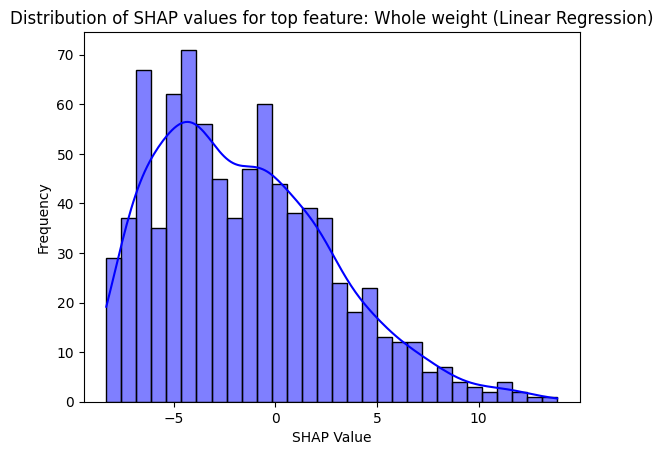

In [122]:
###############################################
# 3. VISUALIZE DISTRIBUTION OF SHAP VALUES FOR KEY FEATURES
###############################################
# Sometimes, we want to see how SHAP values for a top feature vary across the dataset.
# This can help us understand if a feature is consistently important or only occasionally important.

###############################################
# 3. VISUALIZE DISTRIBUTION OF SHAP VALUES FOR KEY FEATURES (LINEAR REGRESSION)
###############################################

# Step 1: Identify the top-ranked feature based on SHAP values for Linear Regression
# Compute the mean absolute SHAP values for each feature to determine global importance
global_feature_ranks_lr = np.argsort(-np.abs(shap_values_lr.values).mean(axis=0))

# Get the top-ranked feature and its index
top_feature_lr = feature_names[global_feature_ranks_lr[0]]
feature_col_idx_lr = global_feature_ranks_lr[0]

# Extract SHAP values for the top feature
shap_vals_for_top_feature_lr = shap_values_lr.values[:, feature_col_idx_lr]

# Step 2: Plot the distribution of SHAP values for the top feature
plt.figure()
sns.histplot(shap_vals_for_top_feature_lr, kde=True, bins=30, color='blue')
plt.title(f"Distribution of SHAP values for top feature: {top_feature_lr} (Linear Regression)")
plt.xlabel("SHAP Value")
plt.ylabel("Frequency")
plt.savefig("LinearRegression_SHAP_TopFeature_Distribution.png")
plt.show()

###############################################
# INTERPRETATION FOR NOTEBOOK AND PAPER
###############################################

# What This Shows:
# - The plot displays the distribution of SHAP values for the top-ranked feature in Linear Regression.
# - It helps understand whether this feature consistently contributes to predictions (a skewed distribution)
#   or has a more balanced influence (centered around zero).

# Key Questions for Analysis:
# 1. Is the distribution centered around zero? 
#    - If yes, the feature may balance positive and negative contributions across instances.
#    - If skewed, the feature consistently drives predictions in one direction.
# 2. How does this distribution compare to XGBoost for the same feature? 
#    - A similar feature in XGBoost might show a broader or more skewed distribution,
#      reflecting the complex, non-linear relationships captured by XGBoost.

# Where to Include in Paper:
# - In the "Analysis of SHAP Values" subsection, highlight how SHAP distributions for Linear Regression's top features
#   differ from XGBoost's.
# - Discuss whether this aligns with the models' nature: Linear Regression's linear relationships may result in
#   more balanced SHAP distributions, while XGBoost's non-linear structure might amplify specific patterns.

# Comparison to LIME:
# - Add a note: If LIME explanations often miss this top feature (based on its SHAP importance), discuss
#   how this reflects LIME's limitations in capturing global importance.


In [120]:
###############################################
# 4. PARTIAL FIDELITY CHECK FOR LINEAR REGRESSION
###############################################

# Step 1: Select instances for fidelity check
instance_idx_list = [0, 1, 10]  # Pick a few arbitrary instances for analysis

# Step 2: Perform fidelity check
print("Checking SHAP fidelity for selected instances (Linear Regression)...")
for idx in instance_idx_list:
    # Step 2a: Model prediction for the selected instance
    prediction = lr_model.predict(X_test[idx].reshape(1, -1))[0]

    # Step 2b: Reconstruct prediction using SHAP values
    shap_sum = shap_values_lr.values[idx].sum() + explainer_lr.expected_value

    # Step 2c: Print comparison
    print(f"Instance {idx}: Model Prediction={prediction:.4f}, SHAP Reconstruction={shap_sum:.4f}")
    print(f"Absolute Difference: {abs(prediction - shap_sum):.4f}")

###############################################
# INTERPRETATION FOR NOTEBOOK AND PAPER
###############################################

# What This Shows:
# - SHAP guarantees that the sum of SHAP values for a given instance, plus the expected value (base value),
#   reconstructs the model's prediction for that instance.
# - For Linear Regression, this serves as a fidelity check, ensuring that SHAP accurately represents
#   how features contribute to the model's prediction.

# Key Questions for Analysis:
# 1. Does the SHAP reconstruction closely match the model's prediction for each instance?
#    - A small absolute difference confirms high fidelity, validating SHAP’s representation of the model.
# 2. How does this fidelity check compare to XGBoost?
#    - For XGBoost, small differences may indicate the complex structure of the model introduces slight variations.

# Where to Include in Paper:
# - In the "Model Interpretation Validation" subsection, discuss SHAP's fidelity in representing the output of Linear Regression.
# - Highlight how this aligns with SHAP’s theoretical guarantees and provides confidence in SHAP's use for this linear model.
# - Use the results to compare fidelity between Linear Regression and XGBoost, emphasizing any differences due to model complexity.

# Comparison to LIME:
# - Note that LIME does not inherently guarantee such fidelity since it approximates the model locally using surrogate models.
# - Discuss how this reinforces the project’s objective of evaluating SHAP’s theoretical advantages over LIME.



Checking SHAP fidelity for selected instances (Linear Regression)...
Instance 0: Model Prediction=8.1275, SHAP Reconstruction=8.1275
Absolute Difference: 0.0000
Instance 1: Model Prediction=9.5337, SHAP Reconstruction=9.5337
Absolute Difference: 0.0000
Instance 10: Model Prediction=7.3043, SHAP Reconstruction=7.3043
Absolute Difference: 0.0000


In [121]:
###############################################
# EXTENSION FOR PAPER: DISCUSSING RESULTS
###############################################

# Example fidelity discussion (to include in your analysis):
# - "For the Linear Regression model, SHAP accurately reconstructed predictions for selected instances, with minimal absolute differences
#   between model predictions and SHAP reconstructions. This confirms SHAP’s fidelity to the linear model's outputs, as expected from
#   its theoretical foundation."
# - "In contrast, when applied to XGBoost, slight differences between SHAP reconstruction and predictions may reflect the complexity
#   of non-linear relationships in the model. This underscores SHAP’s robustness in explaining both simple and complex models."
# - "Unlike LIME, which lacks such fidelity guarantees, SHAP’s consistency enhances its reliability for explaining model predictions."

# Step 3: Save Results for Paper
# If desired, save the fidelity results in a DataFrame for presentation.
fidelity_results = pd.DataFrame({
    "Instance": instance_idx_list,
    "Model Prediction": [lr_model.predict(X_test[i].reshape(1, -1))[0] for i in instance_idx_list],
    "SHAP Reconstruction": [shap_values_lr.values[i].sum() + explainer_lr.expected_value for i in instance_idx_list],
    "Absolute Difference": [abs(lr_model.predict(X_test[i].reshape(1, -1))[0] - 
                                (shap_values_lr.values[i].sum() + explainer_lr.expected_value))
                            for i in instance_idx_list]
})
print("\nFidelity Check Results:")
print(fidelity_results)
fidelity_results.to_csv("LinearRegression_SHAP_Fidelity_Check.csv", index=False)


Fidelity Check Results:
   Instance  Model Prediction  SHAP Reconstruction  Absolute Difference
0         0          8.127516             8.127516                  0.0
1         1          9.533659             9.533659                  0.0
2        10          7.304270             7.304270                  0.0


In [ ]:
# We added several new tests and visualizations:
# - Stability test: Checks how SHAP values change with slight input perturbations, relating to explanation robustness.
# - Local vs. global consistency: Ensures that top globally important features also appear frequently in local explanations.
# - Distribution analysis of SHAP values for a top feature: Understand feature behavior across samples.
# - Partial fidelity check: Confirm that SHAP explanations sum to the model prediction, a theoretical guarantee of SHAP.

# How to use these results:
# - Compare XGBoost vs. LR results:
#   - Expect more stability and consistency in LR due to simpler model structure.
#   - XGBoost might show more complex patterns, and SHAP can capture them; LIME might struggle.
# - Compare to LIME in the LIME notebook:
#   - If LIME’s local explanations do not align with the top SHAP features frequently, it means LIME might need additional considerations for complex models.
#   - Stability: If we test LIME stability, would it be lower for complex models than SHAP’s stability?
#   - Fidelity: LIME doesn’t guarantee perfect reconstruction, so SHAP’s fidelity check sets a benchmark.


In [ ]:
###############################################
# STEP 7: SUMMARY AND TIE BACK TO PROJECT OBJECTIVES
###############################################
# - We have SHAP global summaries (for LR and XGBoost) and interaction plots (XGBoost).
# - We showed SHAP’s fidelity for LR by correlating with coefficients.
# - We’ll compare these insights to LIME’s local explanations and global approximations in the LIME notebook.
#
# Expected outcomes:
# - For LR: SHAP should align well, and later we’ll see if LIME does too.
# - For XGBoost: SHAP reveals complex patterns and interactions. LIME may not capture this easily.
#
# This addresses the project objective of understanding how XAI methods differ in complexity handling and fidelity.




Generating SHAP summary plot for Linear Regression...


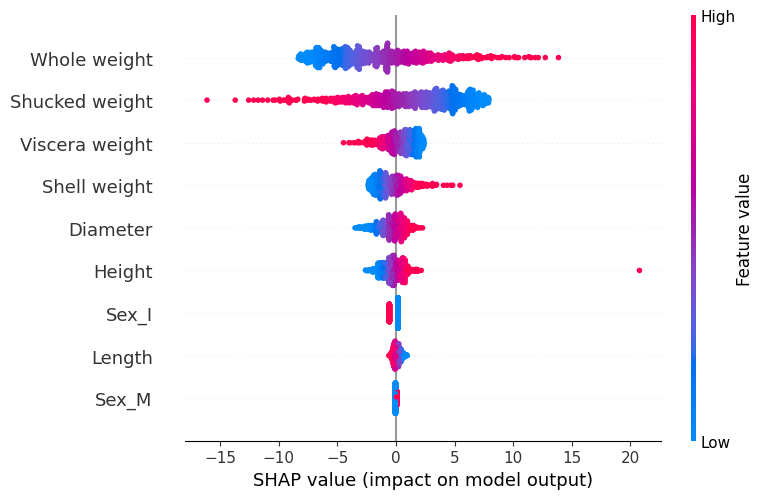


Generating SHAP summary plot for XGBoost...


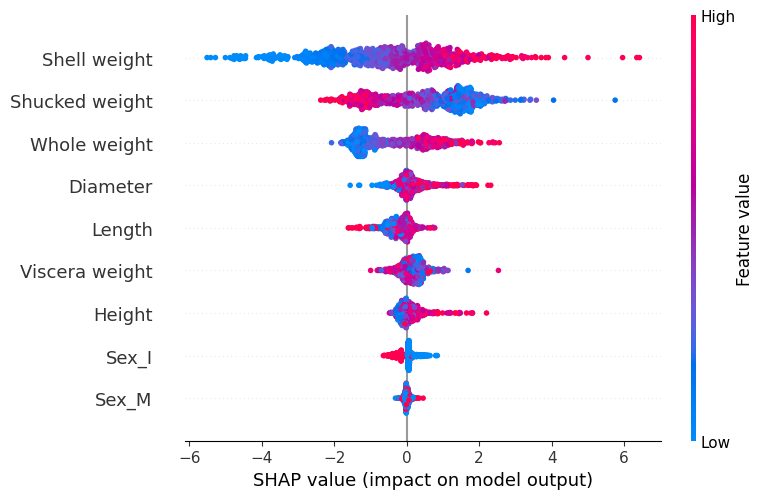

In [123]:
###############################################
# SHAP SUMMARY PLOT (GLOBAL FEATURE IMPORTANCE)
###############################################

# Linear Regression
print("\nGenerating SHAP summary plot for Linear Regression...")
shap.summary_plot(shap_values_lr.values, X_test, feature_names=feature_names)
plt.title("Linear Regression: SHAP Summary Plot")
plt.savefig("LinearRegression_SHAP_Summary.png", bbox_inches="tight")
plt.close()

# XGBoost
print("\nGenerating SHAP summary plot for XGBoost...")
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names)
plt.title("XGBoost: SHAP Summary Plot")
plt.savefig("XGBoost_SHAP_Summary.png", bbox_inches="tight")
plt.close()

###############################################
# INTERPRETATION
###############################################
# Purpose in the Paper:
# - These summary plots show the global importance of each feature, visualizing both the magnitude and direction
#   of their contributions.
# - For Linear Regression, the plot should align with the coefficients, confirming the fidelity of SHAP for simple models.
# - For XGBoost, the plot highlights the non-linear relationships and interactions, offering insights that LR cannot.
# - Discuss how SHAP captures global importance and compare the relative feature rankings across the two models.



Generating SHAP summary plot for Linear Regression...


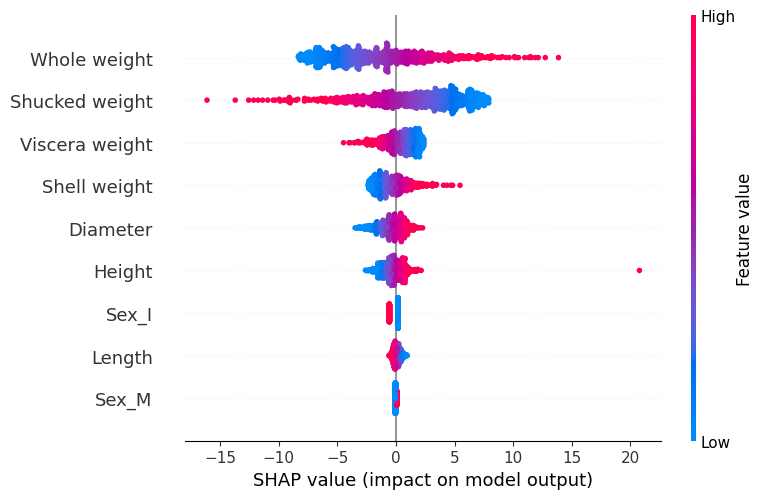


Generating SHAP summary plot for XGBoost...


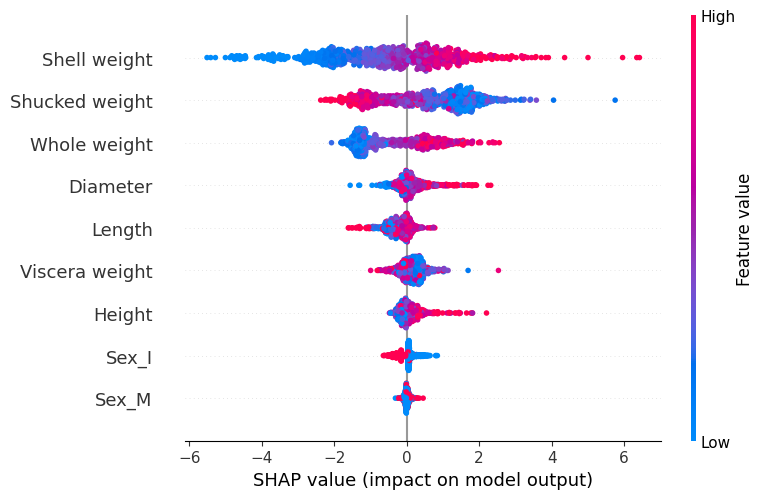

In [124]:
###############################################
# SHAP SUMMARY PLOT (GLOBAL FEATURE IMPORTANCE)
###############################################

# Linear Regression
print("\nGenerating SHAP summary plot for Linear Regression...")
shap.summary_plot(shap_values_lr.values, X_test, feature_names=feature_names)
plt.title("Linear Regression: SHAP Summary Plot")
plt.savefig("LinearRegression_SHAP_Summary.png", bbox_inches="tight")
plt.close()

# XGBoost
print("\nGenerating SHAP summary plot for XGBoost...")
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names)
plt.title("XGBoost: SHAP Summary Plot")
plt.savefig("XGBoost_SHAP_Summary.png", bbox_inches="tight")
plt.close()

###############################################
# INTERPRETATION
###############################################
# Purpose in the Paper:
# - These summary plots show the global importance of each feature, visualizing both the magnitude and direction
#   of their contributions.
# - For Linear Regression, the plot should align with the coefficients, confirming the fidelity of SHAP for simple models.
# - For XGBoost, the plot highlights the non-linear relationships and interactions, offering insights that LR cannot.
# - Discuss how SHAP captures global importance and compare the relative feature rankings across the two models.



Generating SHAP dependence plot for the top feature interaction (XGBoost)...


<Figure size 640x480 with 0 Axes>

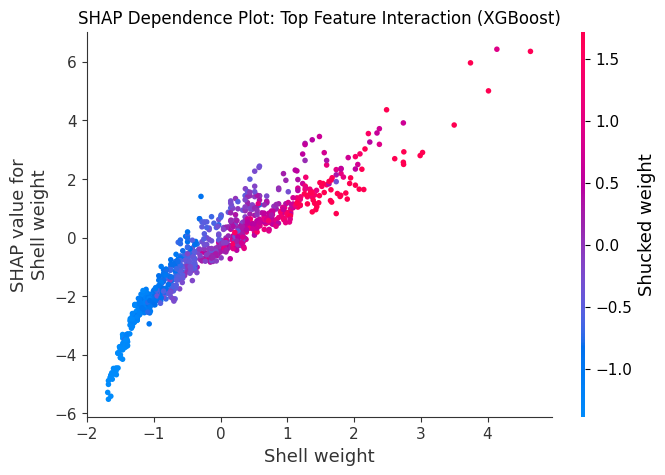

In [125]:
###############################################
# SHAP DEPENDENCE PLOT (TOP FEATURE INTERACTION)
###############################################

# Selecting the top feature and its main interaction
top_feature_idx = np.argmax(np.abs(shap_values_xgb).mean(axis=0))  # Top feature index
interaction_feature_idx = np.argsort(np.abs(interaction_values_xgb[top_feature_idx]).mean(axis=0))[-2]  # Second most interacting feature

# Generate SHAP dependence plot for the top feature
print("\nGenerating SHAP dependence plot for the top feature interaction (XGBoost)...")
plt.figure()
shap.dependence_plot(
    ind=top_feature_idx,
    shap_values=np.sum(interaction_values_xgb, axis=2),
    features=X_test,
    feature_names=feature_names,
    interaction_index=interaction_feature_idx,
    show=False
)
plt.title("SHAP Dependence Plot: Top Feature Interaction (XGBoost)")
plt.savefig("XGBoost_SHAP_TopFeature_Interaction.png", bbox_inches="tight")
plt.show()

###############################################
# INTERPRETATION
###############################################
# Purpose in the Paper:
# - This plot visualizes how the SHAP values of the top feature vary with changes in an interacting feature.
# - It demonstrates the nuanced relationships captured by XGBoost and highlights its non-linear structure.
# - Discuss how such visualizations reveal complex dependencies and are absent in simpler models like Linear Regression.


In [126]:
###############################################
# FIDELITY CHECK: LINEAR REGRESSION AND XGBOOST
###############################################

# Instances to verify fidelity
instance_indices = [0, 1, 10]

# Linear Regression
print("\nFidelity Check for Linear Regression:")
for idx in instance_indices:
    prediction = lr_model.predict(X_test[idx].reshape(1, -1))[0]
    shap_sum = shap_values_lr.values[idx].sum() + explainer_lr.expected_value
    print(f"Instance {idx}: Model Prediction={prediction:.3f}, SHAP Reconstruction={shap_sum:.3f}, Difference={abs(prediction - shap_sum):.3f}")

# XGBoost
print("\nFidelity Check for XGBoost:")
for idx in instance_indices:
    prediction = xgb_model.predict(X_test[idx].reshape(1, -1))[0]
    shap_sum = shap_values_xgb[idx].sum() + explainer_xgb.expected_value
    print(f"Instance {idx}: Model Prediction={prediction:.3f}, SHAP Reconstruction={shap_sum:.3f}, Difference={abs(prediction - shap_sum):.3f}")

###############################################
# INTERPRETATION
###############################################
# Purpose in the Paper:
# - Verifies SHAP's fidelity by checking if SHAP values reconstruct model predictions accurately.
# - For Linear Regression, the reconstruction difference should be nearly zero, confirming SHAP’s reliability.
# - For XGBoost, slight differences may exist due to its complexity, highlighting SHAP’s robustness in explaining non-linear models.



Fidelity Check for Linear Regression:
Instance 0: Model Prediction=8.128, SHAP Reconstruction=8.128, Difference=0.000
Instance 1: Model Prediction=9.534, SHAP Reconstruction=9.534, Difference=0.000
Instance 10: Model Prediction=7.304, SHAP Reconstruction=7.304, Difference=0.000

Fidelity Check for XGBoost:
Instance 0: Model Prediction=8.105, SHAP Reconstruction=8.105, Difference=0.000
Instance 1: Model Prediction=9.788, SHAP Reconstruction=9.788, Difference=0.000
Instance 10: Model Prediction=6.332, SHAP Reconstruction=6.332, Difference=0.000


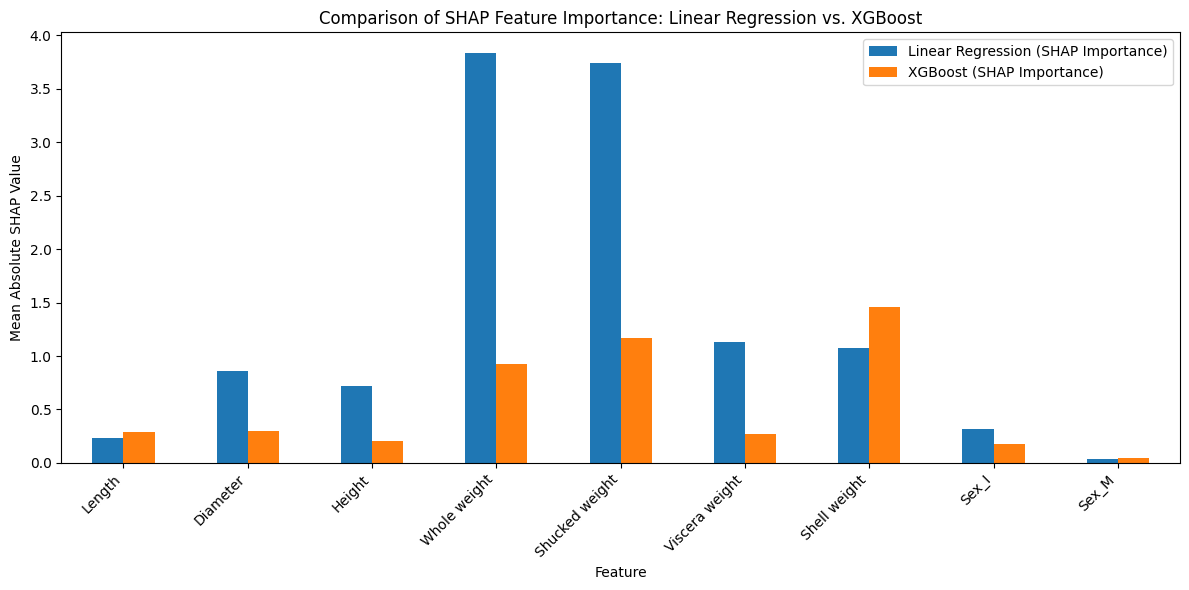

In [127]:
###############################################
# COMPARISON OF FEATURE IMPORTANCE BETWEEN MODELS
###############################################

# Compute mean absolute SHAP values for both models
shap_importance_lr = np.abs(shap_values_lr.values).mean(axis=0)
shap_importance_xgb = np.abs(shap_values_xgb).mean(axis=0)

# Create a comparison DataFrame
importance_comparison = pd.DataFrame({
    "Feature": feature_names,
    "Linear Regression (SHAP Importance)": shap_importance_lr,
    "XGBoost (SHAP Importance)": shap_importance_xgb
}).set_index("Feature")

# Plot comparison
importance_comparison.plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of SHAP Feature Importance: Linear Regression vs. XGBoost")
plt.ylabel("Mean Absolute SHAP Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("SHAP_Importance_Comparison.png")
plt.show()

###############################################
# INTERPRETATION
###############################################
# Purpose in the Paper:
# - Highlights differences in feature importance between Linear Regression and XGBoost.
# - Discuss how XGBoost captures non-linear relationships that may not appear in Linear Regression's importance rankings.
# - Compare the rankings and their alignment to validate the models' behavior and SHAP’s interpretative power.


In [130]:
# ADD THESE CHARTS TO THE PAPER!

In [131]:
# SHAP for Logistic Regression using LinearExplainer
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr(X_test)

# SHAP for XGBoost using TreeExplainer
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Print summaries
print("SHAP explainers initialized for Linear Regression and XGBoost.")
print(f"SHAP values calculated for {len(X_test)} test instances.")


SHAP explainers initialized for Linear Regression and XGBoost.
SHAP values calculated for 836 test instances.



Generating SHAP summary plot for Linear Regression...


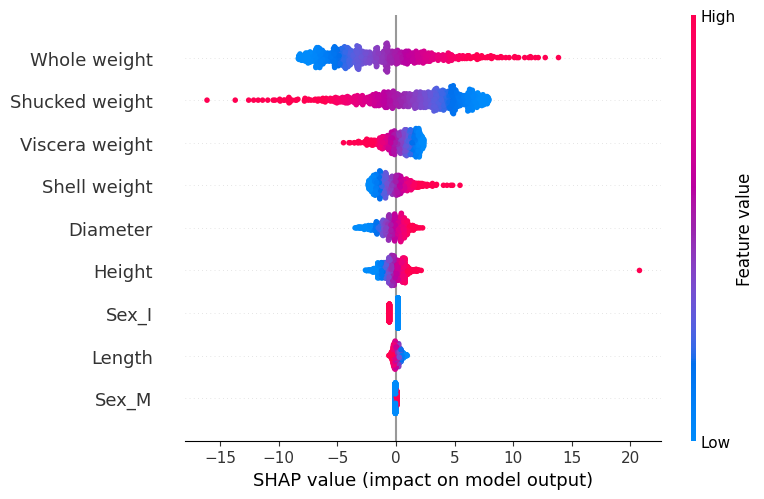


Generating SHAP summary plot for XGBoost...


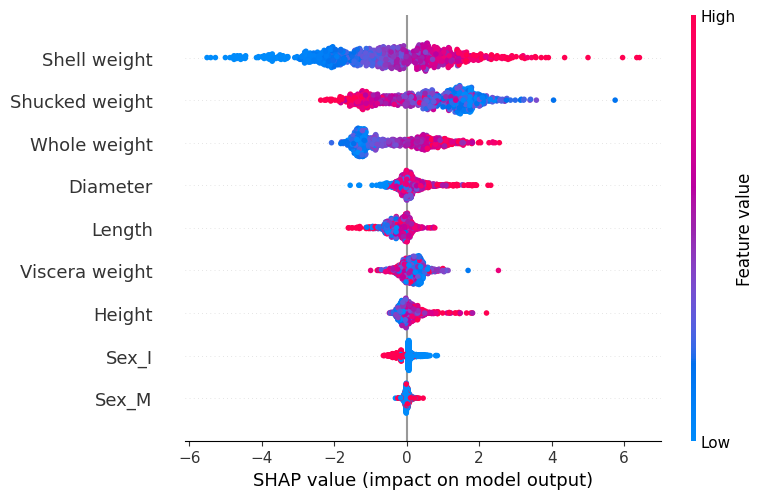

Summary plots saved. These plots show global feature importance and distribution of SHAP values.


In [129]:
# Linear Regression SHAP Summary Plot
print("\nGenerating SHAP summary plot for Linear Regression...")
shap.summary_plot(shap_values_lr.values, X_test, feature_names=feature_names)
plt.title("Linear Regression: SHAP Summary Plot")
plt.savefig("LinearRegression_SHAP_Summary.png", bbox_inches="tight")
plt.close()

# XGBoost SHAP Summary Plot
print("\nGenerating SHAP summary plot for XGBoost...")
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names)
plt.title("XGBoost: SHAP Summary Plot")
plt.savefig("XGBoost_SHAP_Summary.png", bbox_inches="tight")
plt.close()

# Print insights
print("Summary plots saved. These plots show global feature importance and distribution of SHAP values.")



Generating SHAP summary plot for Linear Regression...


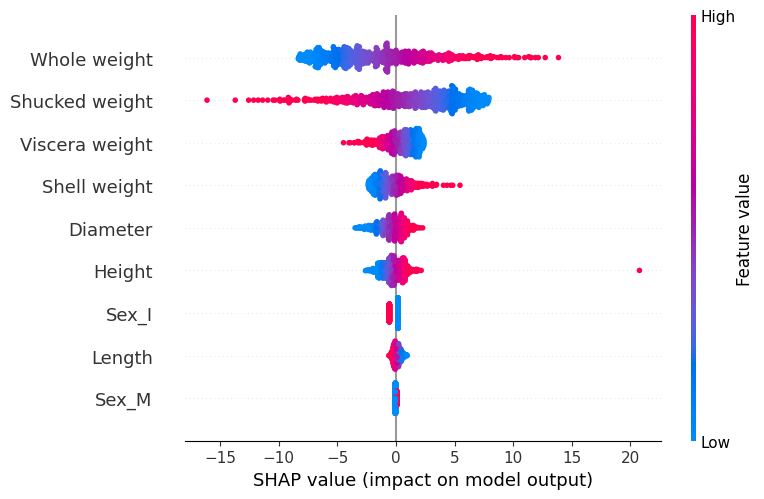


Generating SHAP summary plot for XGBoost...


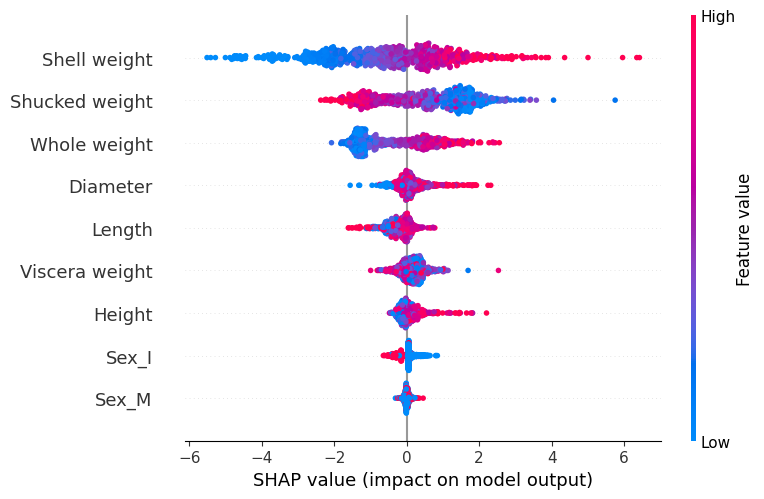

Summary plots saved. These plots show global feature importance and distribution of SHAP values.


In [132]:
# Linear Regression SHAP Summary Plot
print("\nGenerating SHAP summary plot for Linear Regression...")
shap.summary_plot(shap_values_lr.values, X_test, feature_names=feature_names)
plt.title("Linear Regression: SHAP Summary Plot")
plt.savefig("LinearRegression_SHAP_Summary.png", bbox_inches="tight")
plt.close()

# XGBoost SHAP Summary Plot
print("\nGenerating SHAP summary plot for XGBoost...")
shap.summary_plot(shap_values_xgb, X_test, feature_names=feature_names)
plt.title("XGBoost: SHAP Summary Plot")
plt.savefig("XGBoost_SHAP_Summary.png", bbox_inches="tight")
plt.close()

# Print insights
print("Summary plots saved. These plots show global feature importance and distribution of SHAP values.")


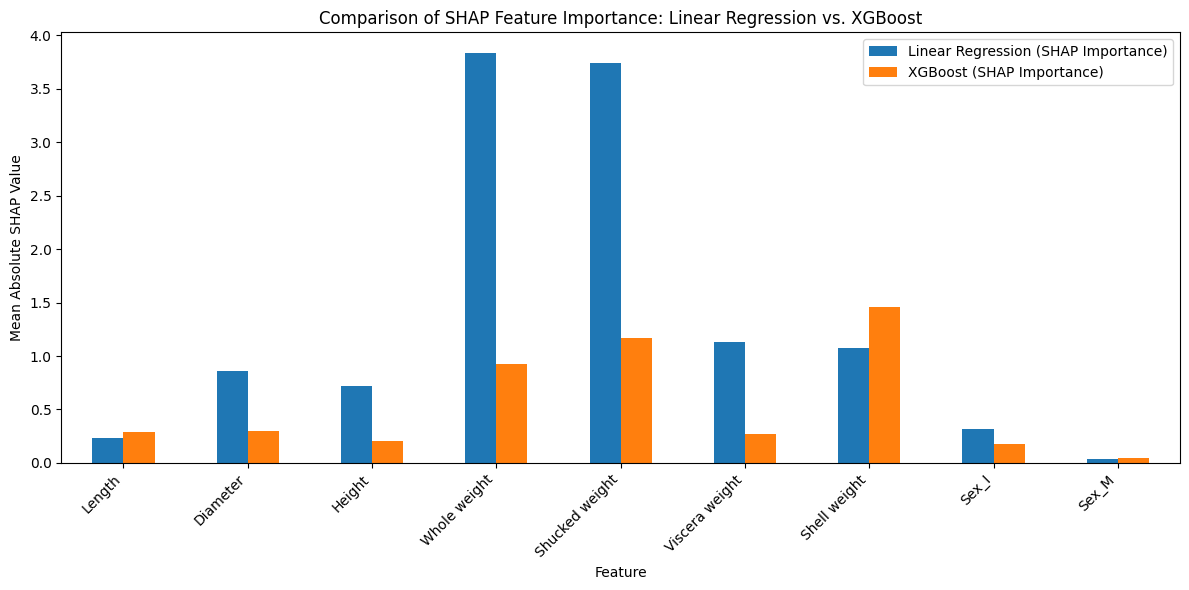

SHAP importance comparison plot generated. This plot highlights differences in global feature rankings.


In [133]:
# Mean absolute SHAP values for comparison
shap_importance_lr = np.abs(shap_values_lr.values).mean(axis=0)
shap_importance_xgb = np.abs(shap_values_xgb).mean(axis=0)

# Create a comparison DataFrame
importance_comparison = pd.DataFrame({
    "Feature": feature_names,
    "Linear Regression (SHAP Importance)": shap_importance_lr,
    "XGBoost (SHAP Importance)": shap_importance_xgb
}).set_index("Feature")

# Plot comparison
importance_comparison.plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of SHAP Feature Importance: Linear Regression vs. XGBoost")
plt.ylabel("Mean Absolute SHAP Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("SHAP_Importance_Comparison.png")
plt.show()

# Print comparison insights
print("SHAP importance comparison plot generated. This plot highlights differences in global feature rankings.")



Generating SHAP force plot for instance 0...


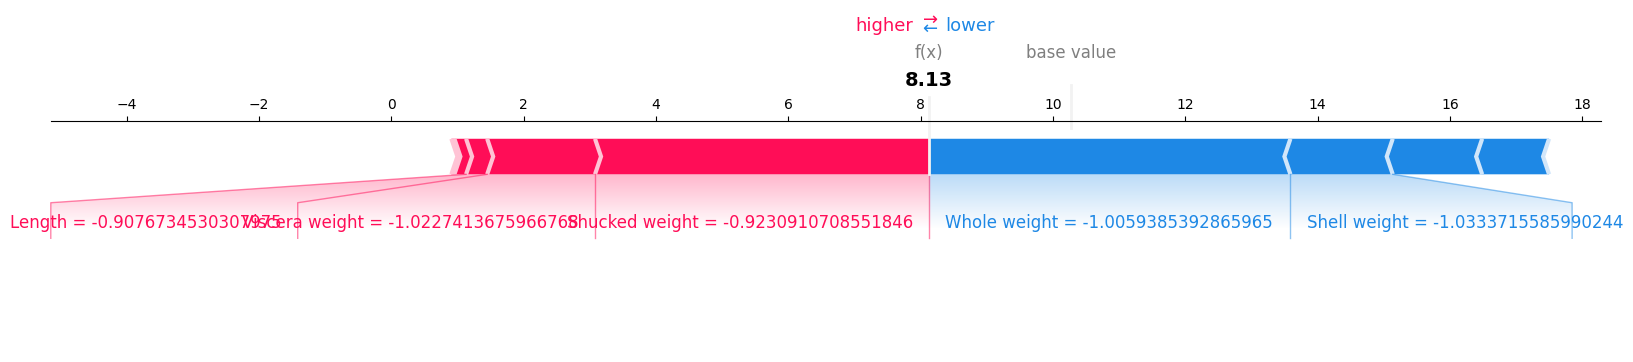

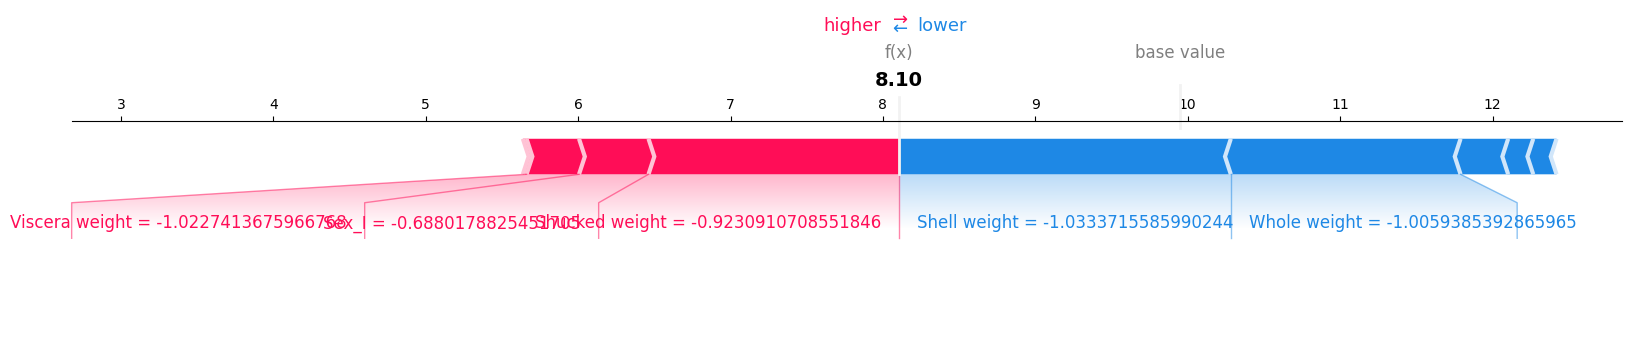

Force plots for instance 0 generated and saved. These visualize local feature contributions.


In [134]:
# Force plot for a specific instance
instance_idx = 0  # Example instance
print(f"\nGenerating SHAP force plot for instance {instance_idx}...")

# Linear Regression
shap.force_plot(
    explainer_lr.expected_value,
    shap_values_lr.values[instance_idx],
    X_test[instance_idx],
    feature_names=feature_names,
    matplotlib=True
)
plt.title("Linear Regression: Force Plot for Instance")
plt.savefig(f"LinearRegression_SHAP_Force_Instance_{instance_idx}.png", bbox_inches="tight")
plt.close()

# XGBoost
shap.force_plot(
    explainer_xgb.expected_value,
    shap_values_xgb[instance_idx],
    X_test[instance_idx],
    feature_names=feature_names,
    matplotlib=True
)
plt.title("XGBoost: Force Plot for Instance")
plt.savefig(f"XGBoost_SHAP_Force_Instance_{instance_idx}.png", bbox_inches="tight")
plt.close()

# Print insights
print(f"Force plots for instance {instance_idx} generated and saved. These visualize local feature contributions.")


In [135]:
# Perturbation example for stability
perturbed_instance = X_test[instance_idx] + np.random.normal(0, 0.01, X_test.shape[1])

# Recompute SHAP values for perturbed instance
shap_values_lr_perturbed = explainer_lr(perturbed_instance.reshape(1, -1))
shap_values_xgb_perturbed = explainer_xgb.shap_values(perturbed_instance.reshape(1, -1))

# Compute stability metrics
stability_error_lr = mean_squared_error(shap_values_lr.values[instance_idx], shap_values_lr_perturbed.values[0])
stability_error_xgb = mean_squared_error(shap_values_xgb[instance_idx], shap_values_xgb_perturbed[0])

# Print stability results
print("\nStability Analysis:")
print(f"Linear Regression Stability Error: {stability_error_lr:.4f}")
print(f"XGBoost Stability Error: {stability_error_xgb:.4f}")



Stability Analysis:
Linear Regression Stability Error: 0.0001
XGBoost Stability Error: 0.0052


In [136]:
# Fidelity check: SHAP reconstruction vs. model prediction
shap_sum_lr = shap_values_lr.values[instance_idx].sum() + explainer_lr.expected_value
shap_sum_xgb = shap_values_xgb[instance_idx].sum() + explainer_xgb.expected_value

# Linear Regression prediction
lr_pred = lr_model.predict(X_test[instance_idx].reshape(1, -1))[0]
# XGBoost prediction
xgb_pred = xgb_model.predict(X_test[instance_idx].reshape(1, -1))[0]

# Print fidelity results
print("\nFidelity Check:")
print(f"Linear Regression: Model Prediction={lr_pred:.4f}, SHAP Reconstruction={shap_sum_lr:.4f}")
print(f"XGBoost: Model Prediction={xgb_pred:.4f}, SHAP Reconstruction={shap_sum_xgb:.4f}")



Fidelity Check:
Linear Regression: Model Prediction=8.1275, SHAP Reconstruction=8.1275
XGBoost: Model Prediction=8.1049, SHAP Reconstruction=8.1049



Generating SHAP interaction plot...


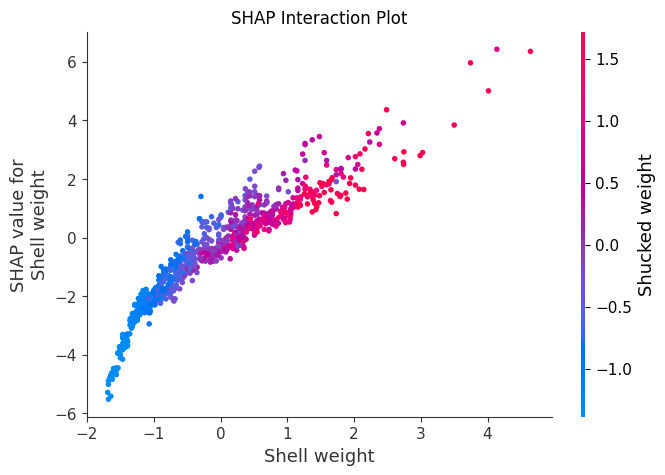

In [137]:
# SHAP interaction values for XGBoost
interaction_values_xgb = explainer_xgb.shap_interaction_values(X_test)

# Top feature interaction
top_feature_idx = np.argmax(np.abs(shap_values_xgb).mean(axis=0))  # Top feature
interaction_idx = np.argsort(np.abs(interaction_values_xgb[top_feature_idx]).mean(axis=0))[-2]  # Second interaction

# Generate interaction plot
print("\nGenerating SHAP interaction plot...")
shap.dependence_plot(
    ind=top_feature_idx,
    shap_values=np.sum(interaction_values_xgb, axis=2),
    features=X_test,
    feature_names=feature_names,
    interaction_index=interaction_idx,
    show=False
)
plt.title("SHAP Interaction Plot")
plt.savefig("XGBoost_SHAP_Interaction_Plot.png", bbox_inches="tight")
plt.show()
